In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "compare_trainings"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [7]:
def n_presel_jets(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jets)

[None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
networks = dict(
    mp='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221124_ranger_lr0.0047_batch512_m7m10m12/',
    mp300k='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221205_ranger_lr0.0047_batch512_m7m10m12_300k/',
    mp500k='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221205_ranger_lr0.0047_batch512_m7m10m12_500k/',
)

In [10]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)

class Networks:
    def __init__(self, signal, bkg, data, quadh_path=None):
        self.signal = signal.copy()
        self.bkg = bkg.copy()
        self.data = data.copy()

        self.quadh_path = quadh_path

        (self.signal+self.bkg+self.data).apply(lambda t : eightb.load_quadh(t, quadh_path), report=True)
        self.signal.apply(nfound_higgs)

In [12]:
models = {
    key : Networks(signal, bkg, data, path)
    for key, path in networks.items()
}

100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


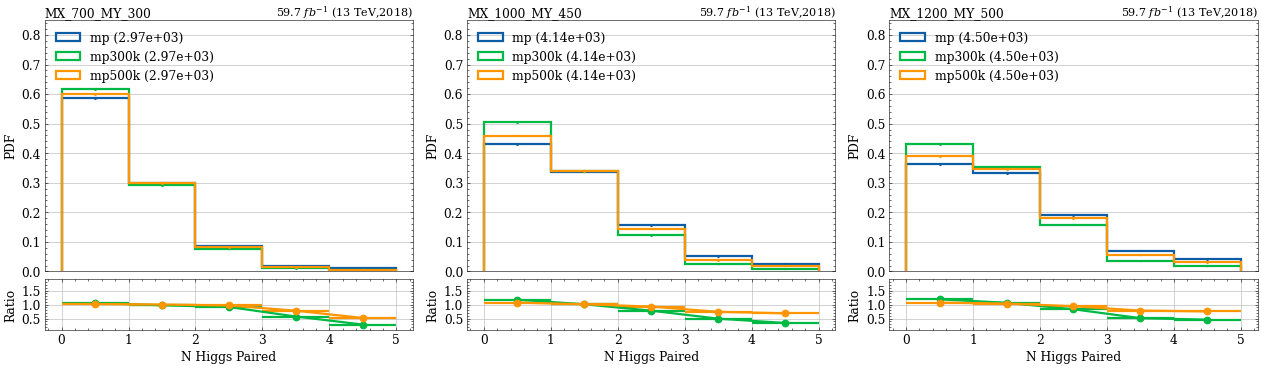

In [47]:
fig, axs = study.get_figax(nvar=3, dim=-1)
for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        label = [ model for model in models ],
        text=(0.0, 1.0, sample.sample),
        text_style=dict(ha='left', va='bottom'),
        h_color=None,
        legend=True,
        efficiency=True,
        ylim=(0,0.85), grid=True,
        varlist=['nfound_paired_h'],
        xlabels=['N Higgs Paired'],
        ratio=True, r_inv=True,
        figax=(fig, axs.flat[i])
    )

study.save_fig(fig, 'compare_ndata/t8btag_signal_reco_eff')

100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


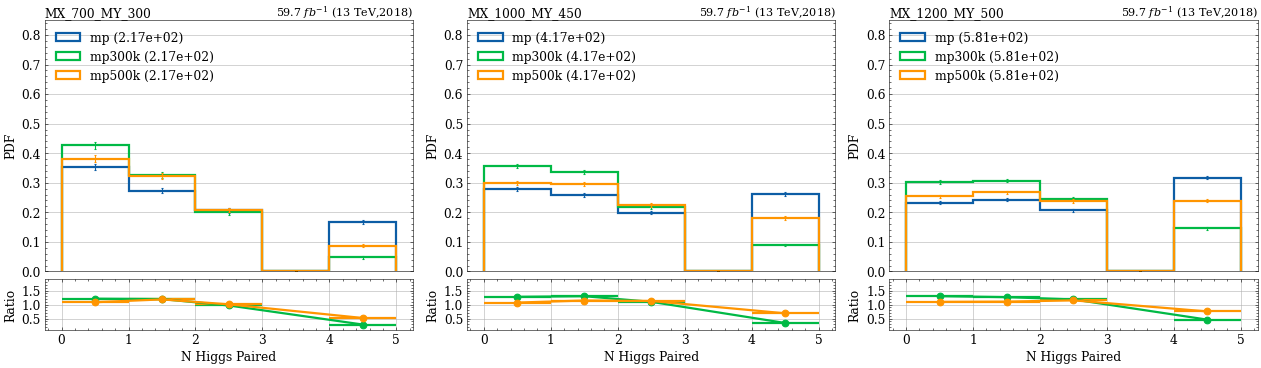

In [48]:
fig, axs = study.get_figax(nvar=3, dim=-1)
for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        masks=lambda t : t.nfound_select_h==4,
        label = [ model for model in models ],
        text=(0.0, 1.0, sample.sample),
        text_style=dict(ha='left', va='bottom'),
        h_color=None,
        legend=True,
        efficiency=True,
        ylim=(0,0.85), grid=True,
        varlist=['nfound_paired_h'],
        xlabels=['N Higgs Paired'],
        ratio=True, r_inv=True,
        figax=(fig, axs.flat[i])
    )

study.save_fig(fig, 'compare_ndata/fullres_signal_reco_eff')

100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


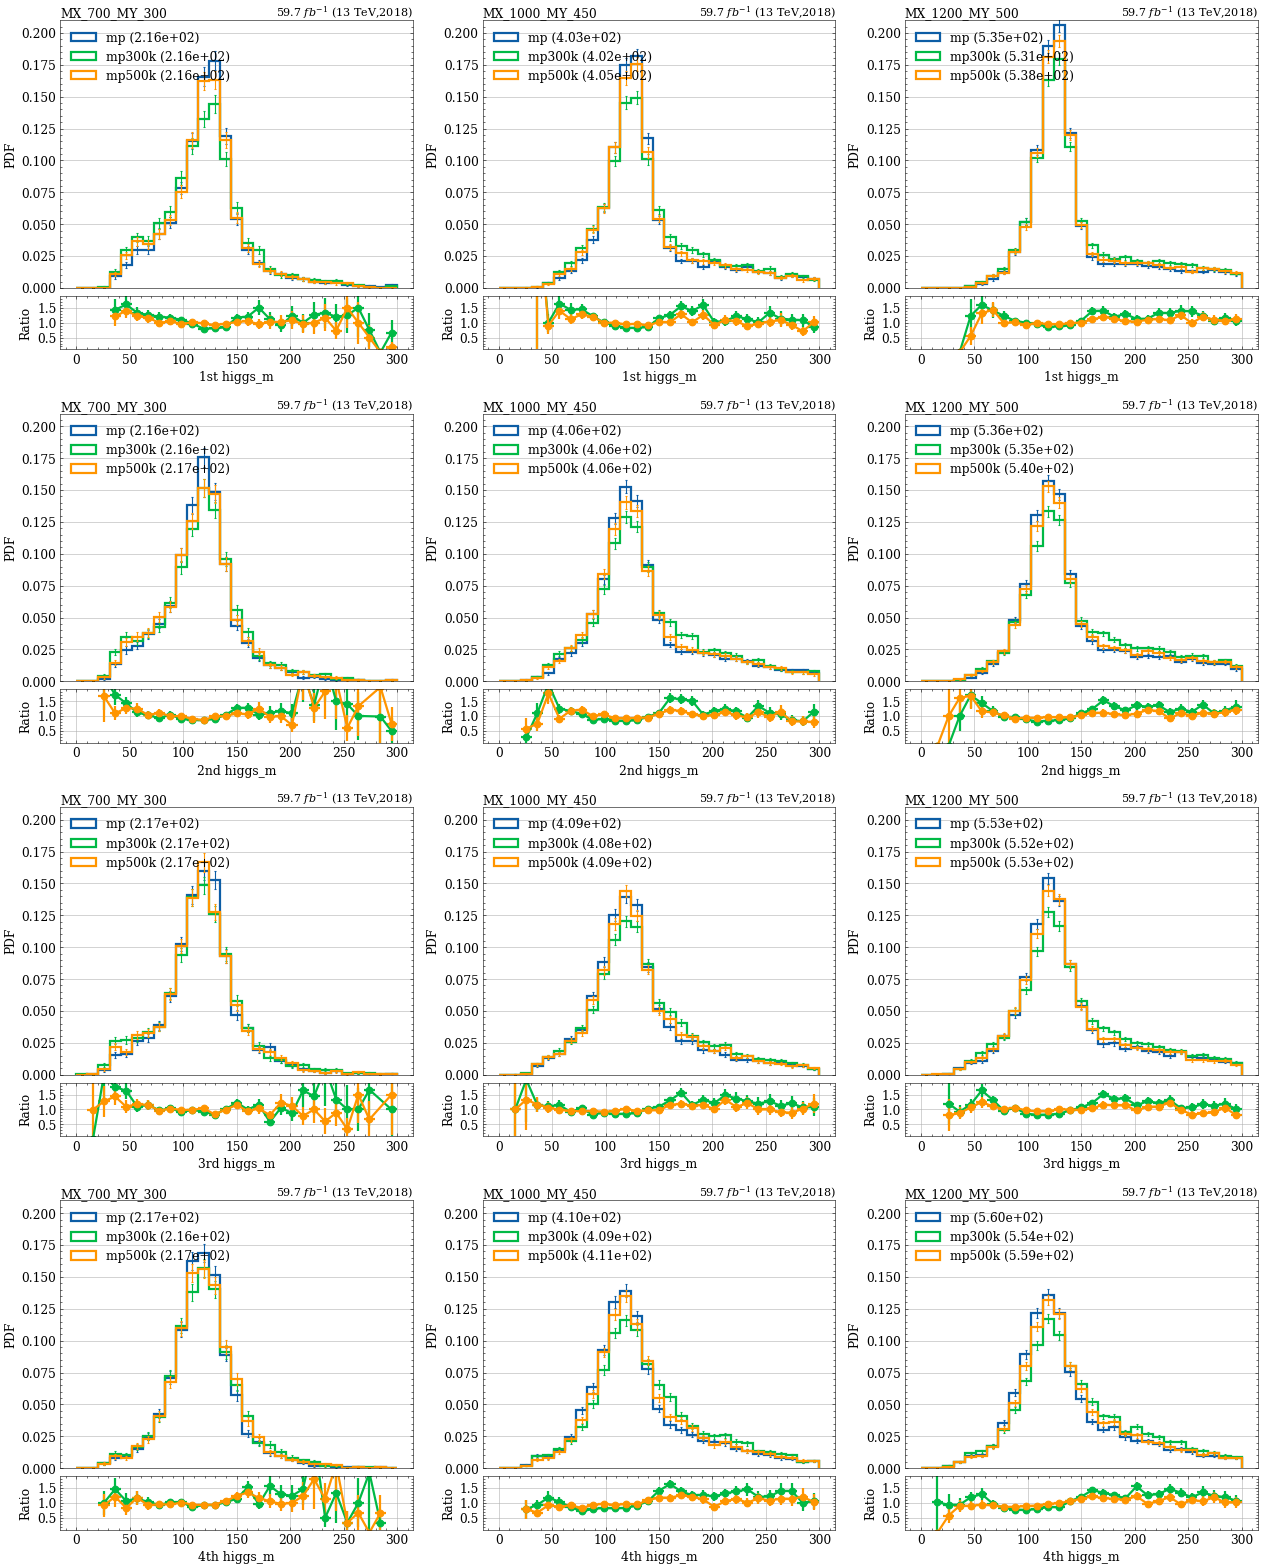

In [45]:
fig, axs = study.get_figax(nvar=3*4, dim=(-1, 3))
for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        masks=lambda t : t.nfound_select_h==4,
        label = [ model for model in models ],
        text=(0.0, 1.0, sample.sample),
        text_style=dict(ha='left', va='bottom'),
        h_color=None,
        legend=True,
        efficiency=True,
        ylim=(0,0.21), grid=True,
        varlist=[f'higgs_m[:,{i}]' for i in range(4) ],
        binlist=[(0,300,30)]*4,
        ratio=True, r_inv=True,
        figax=(fig, axs[:,i])
    )

study.save_fig(fig, 'compare_ndata/fullres_signal_higgs_m')

100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


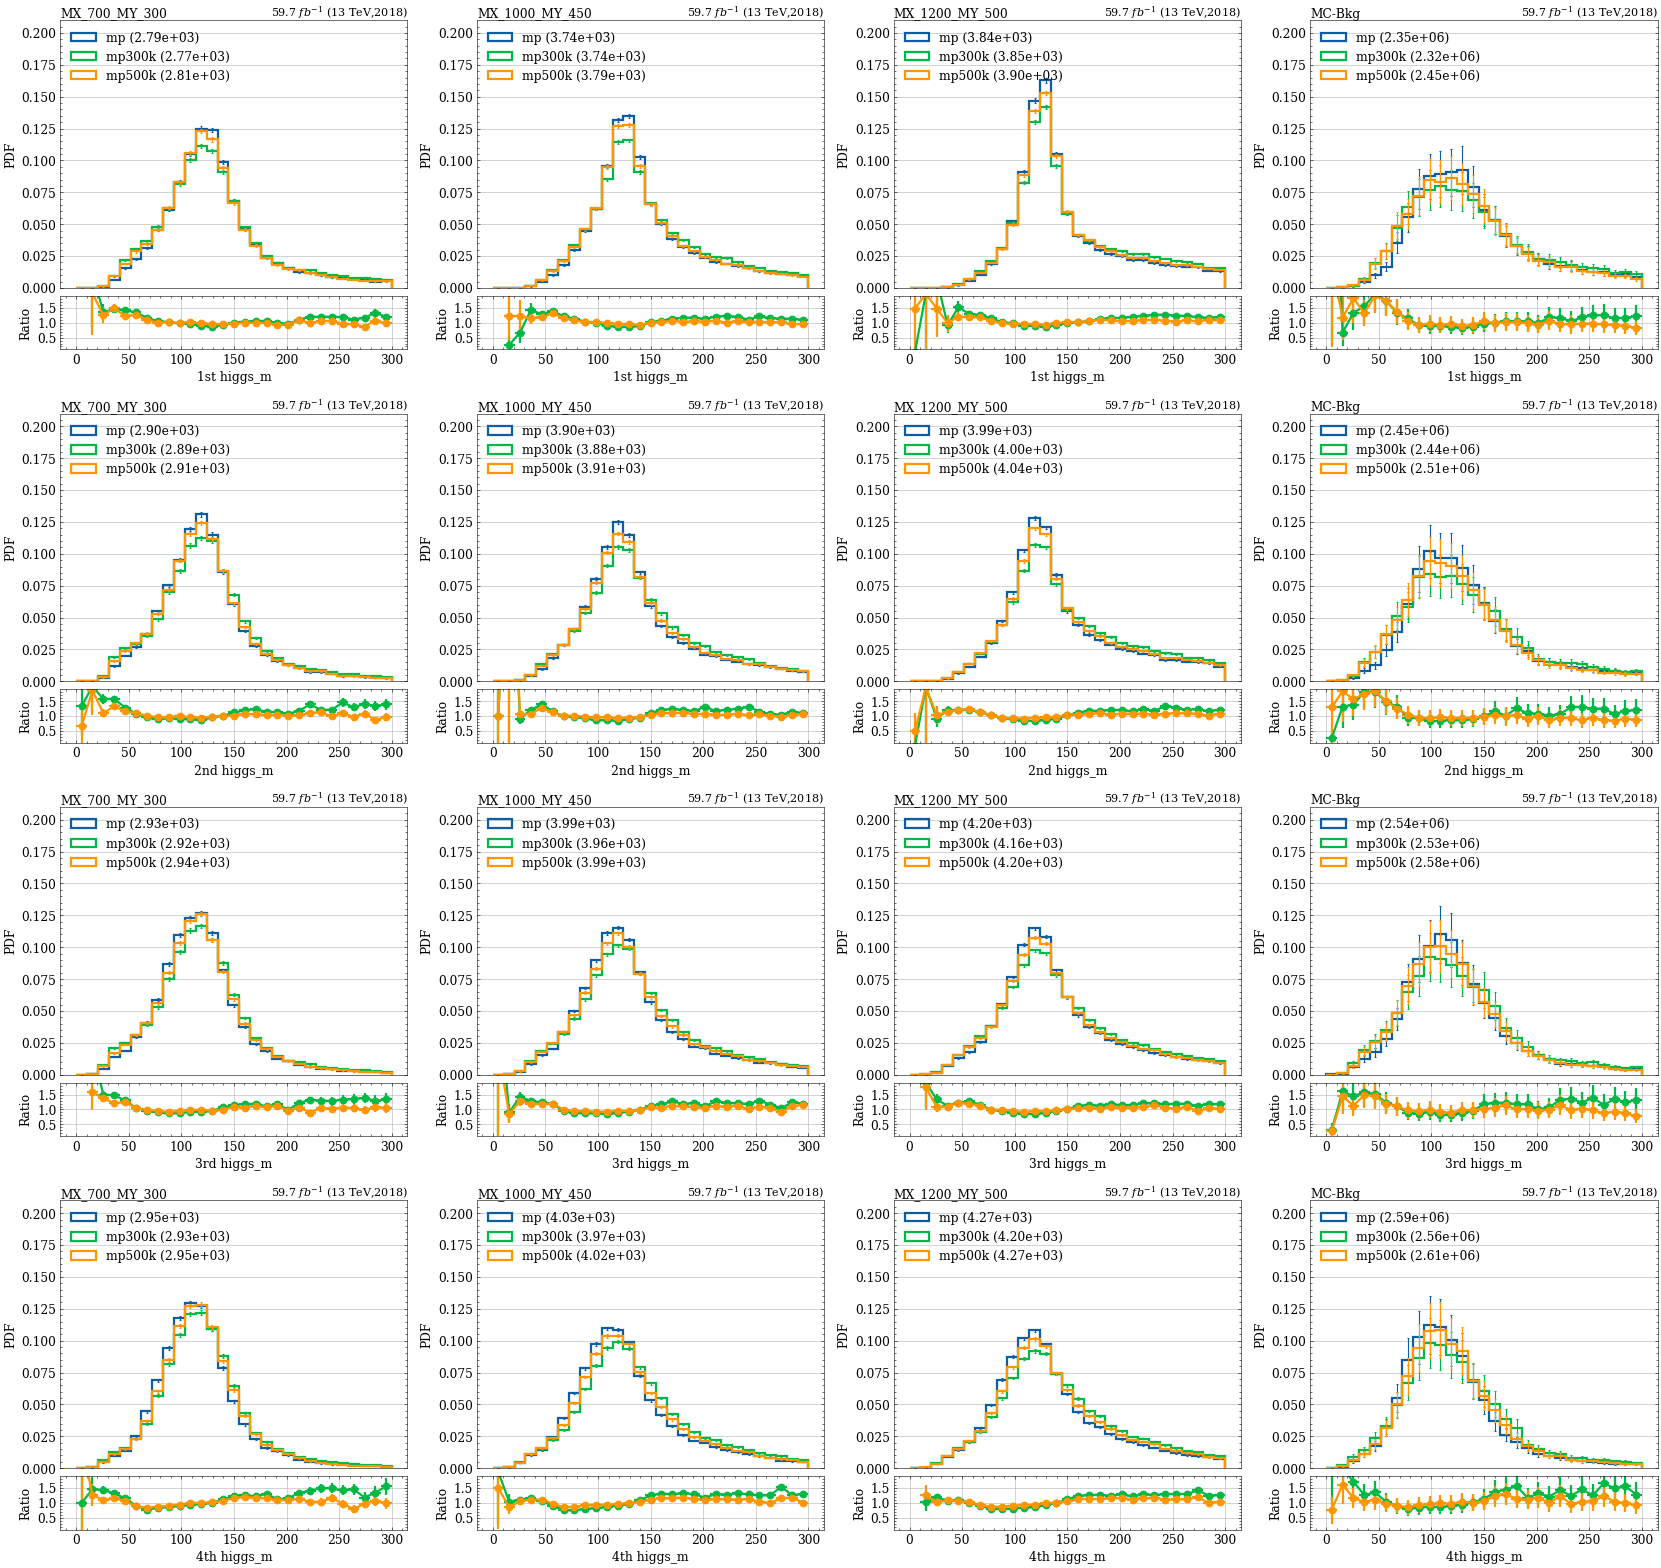

In [46]:
fig, axs = study.get_figax(nvar=4*4, dim=(-1,4))

kwargs = dict(
    label = [ model for model in models ],
    text_style=dict(ha='left', va='bottom'),
    h_color=None,
    legend=True,
    efficiency=True,
    ylim=(0,0.21), grid=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    ratio=True, r_inv=True,
)

for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        text=(0.0, 1.0, sample.sample),
        figax=(fig, axs[:,i]),
        **kwargs
    )

study.quick_region( 
        *[ model.bkg for model in models.values() ],
        text=(0.0, 1.0, 'MC-Bkg'),
        figax=(fig, axs[:,i+1]),
        **kwargs
    )

study.save_fig(fig, 'compare_ndata/t8btag_higgs_m')